In [1]:
%matplotlib inline
import torch
from torch.utils.data import DataLoader
import numpy as np
import cv2 as cv
from ProgressNerf.Registries.DataloaderRegistry import get_dataloader
from ProgressNerf.Registries.RaypickerRegistry import get_raypicker
from ProgressNerf.Registries.RaysamplerRegistry import get_raysampler
from ProgressNerf.Registries.EncoderRegistry import get_encoder
from ProgressNerf.Registries.ModelRegistry import get_model
import ProgressNerf.Dataloading.ToolsPartsDataloader
from ProgressNerf.Dataloading.SemiSynDataloader import SemisynDataloader
#from ProgressNerf.Dataloading.DNerfDataloader import DNerfDataloader
from ProgressNerf.Dataloading.YCBVideoDataloader import YCBVideoDataloader
import ProgressNerf.Raycasting.RandomRaypicker
import ProgressNerf.Raycasting.NearFarRaysampler
import ProgressNerf.Encoders.PositionalEncoder
import ProgressNerf.Raycasting.WeightedRaypicker
import ProgressNerf.Raycasting.PerturbedRaysampler
import ProgressNerf.Models.OGNerf
import ProgressNerf.Models.ConfigurableFastNerf
from ProgressNerf.Architectures.OGNerfArch import OGNerfArch
from ProgressNerf.Architectures.VoxelGridCachedNerf import VoxelGridCachedNerf
from ProgressNerf.Architectures.ConfigurableVoxelGridCachedNerf import ConfigurableVoxelGridCachedNerf
from ProgressNerf.Utils.VoxelGrid import VoxelGrid
from ProgressNerf.Utils.CameraUtils import BuildCameraMatrix
import yaml
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import math
from tqdm.auto import tqdm
import time


In [2]:
config_file = "/home/stanlew/src/ProgressNerf/configs/VoxelGridNerf/ycbVideo_Soup.yml"
arch = VoxelGridCachedNerf(config_file)

loading config at /home/stanlew/src/ProgressNerf/configs/VoxelGridNerf/ycbVideo_Soup.yml
parsing config
initializing optimizer
loading model  & optimizer params from /home/stanlew/Documents/ProgressNerfModels/ycb_video/soup_can_4/epoch_200
resuming training from epoch 201...


In [23]:
test_pose = np.eye(4)
# just a random pose taken from the ToolParts dataset (scene 00_01, test set, sample #8)
test_pose[0:3,3] = np.array([0.0,0.0,0.5])
#pose_quat = np.array([0.28405447470305767, 0.7107763388551345, 0.5857394722169705, -0.26649450690745147])
#rot_matrix = R.from_quat(np.concatenate((pose_quat[1:4], [pose_quat[0]]))).as_matrix()
rot_matrices = []
for i in np.linspace(45,-45,10):
    rot_matrix = R.from_euler('xyz', [180-35, i, i], degrees=True).as_matrix()
    rot_matrices.append(torch.Tensor(rot_matrix).to("cuda:1"))
    
test_pose = torch.Tensor(test_pose).unsqueeze(0).to("cuda:1")

configurations = torch.linspace(0.2, 0.06, 10).to("cuda:1")

In [27]:
tic = time.perf_counter()
for i in range(1):
    rot_matrix = rot_matrices[i]
    test_pose[0, 0:3,0:3] = rot_matrix
    test_cam_pose = torch.linalg.inv(test_pose)
    rgb_output, depth_output = arch.doEvalRendering(test_cam_pose, use_cache=False)
    cv.imwrite("{0}.png".format(i+30), rgb_output[0].cpu().numpy()[...,::-1]*255)
toc = time.perf_counter()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


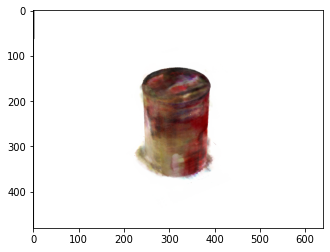

In [28]:
plt.imshow(rgb_output.cpu()[0].numpy())

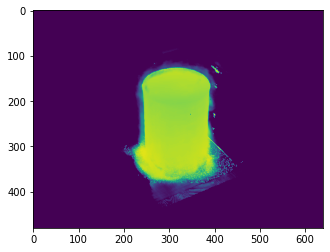

In [29]:
plt.imshow(depth_output.cpu()[0].numpy())

In [22]:
print(toc - tic)

12.81160556001123
